In [2]:
#Author : Venkata Buddhiraju
import joblib
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
import matplotlib.pyplot as plt

import prepare_data

In [3]:
def preprocess_test_data(test_df, scaler, encoder, categorical_cols, numerical_cols):
    # Scale numerical columns
    test_df[numerical_cols] = scaler.transform(test_df[numerical_cols])

    # Encode categorical columns
    encoded_categorical_test = encoder.transform(test_df[categorical_cols])
    encoded_categorical_df_test = pd.DataFrame(
        encoded_categorical_test,
        columns=encoder.get_feature_names_out(categorical_cols),
        index=test_df.index
    )

    # Drop original categorical columns and concatenate the encoded DataFrame
    test_df = pd.concat([test_df.drop(categorical_cols, axis=1), encoded_categorical_df_test], axis=1)

    # Drop unnecessary columns (e.g., 'Id')
    test_df = test_df.drop(columns=['Id'], errors='ignore')

    return test_df

In [4]:
X_train, X_test, y_train, y_test, output_test = prepare_data.get_training_data()

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
joblib.dump(rf_model, "random_forest_model.joblib")

# Train and save Support Vector Machine model
# Remove rows with NaN values in X_train
X_train_svm = X_train.dropna()
# Ensure y_train is aligned with the updated X_train
y_train_svm = y_train.loc[X_train_svm.index]
svm_model = SVR(kernel='linear')
svm_model.fit(X_train_svm, y_train_svm)
joblib.dump(svm_model, "svm_model.joblib")

lr_model = LogisticRegression(random_state=42, max_iter=1000)

# Train the model on X_train and y_train
lr_model.fit(X_train_svm, y_train_svm)
joblib.dump(lr_model, "lr_model.joblib")



['lr_model.joblib']

In [6]:
# Predict on the test data
test_df = pd.read_csv('../docs/test.csv')

rf_model_loaded = joblib.load("random_forest_model.joblib")
rf_predictions = rf_model_loaded.predict(X_test)
rf_predictions_output = rf_model_loaded.predict(output_test)

# Remove rows with NaN values in X_test
X_test_svm = X_test.dropna()

# Ensure y_test is aligned with the updated X_test
y_test_svm = y_test.loc[X_test_svm.index]
svm_model_loaded = joblib.load("svm_model.joblib")
svm_predictions = svm_model_loaded.predict(X_test_svm)
# Ensure y_test is aligned with the updated X_test

lr_model_loaded = joblib.load("lr_model.joblib")
lr_predictions = lr_model.predict(X_test_svm)

# Calculate the mean squared error
rf_mse = mean_squared_error(y_test, rf_predictions)
# Calculate the root mean squared error
rf_rmse = np.sqrt(rf_mse)
# Print the result
print(f"Root Mean Squared Error of Random Forest: {rf_rmse}")

svm_mse = mean_squared_error(y_test_svm, svm_predictions)
svm_rmse = np.sqrt(svm_mse)
print(f"Root Mean Squared Error of SVM: {svm_rmse}")

lr_mse = mean_squared_error(y_test_svm, lr_predictions)
lr_rmse = np.sqrt(lr_mse)
print(f"Root Mean Squared Error of LR: {lr_rmse}")

rf_predictions_aligned = pd.Series(rf_predictions, index=X_test.index)
output = pd.read_csv('../docs/test.csv')
output['SalePriceRF'] = rf_predictions_output

output.to_csv("RF_Predictions.csv")

Root Mean Squared Error of Random Forest: 30302.911454230674
Root Mean Squared Error of SVM: 86980.13889471698
Root Mean Squared Error of LR: 44004.15129922011


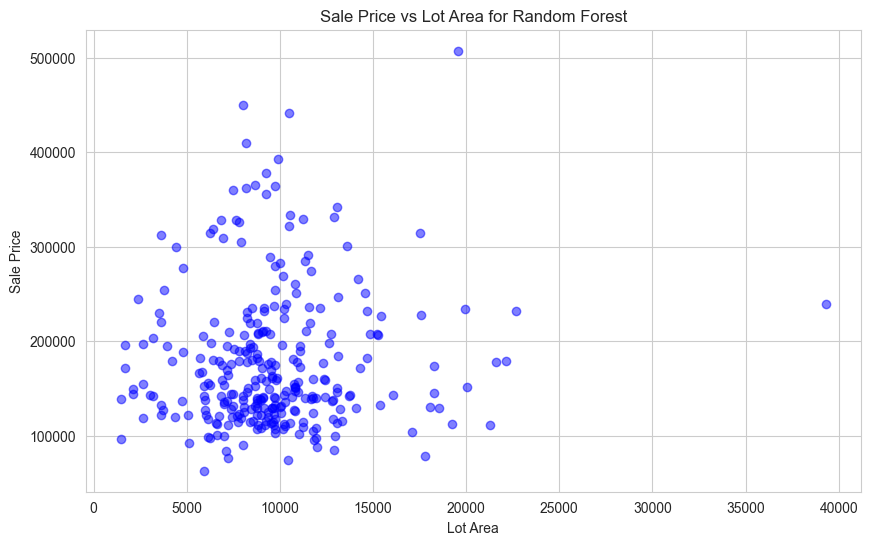

In [4]:
plt.figure(figsize=(10, 6))
plt.scatter(output['LotArea'], output['SalePriceRF'], alpha=0.5, color='blue')
plt.title('Sale Price vs Lot Area for Random Forest')
plt.xlabel('Lot Area')
plt.ylabel('Sale Price')
plt.grid(True)
plt.show()